In [1]:
import os
import glob as glob
import timecorr as tc
import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA, IncrementalPCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
%matplotlib inline  
import timecorr as tc
from timecorr.helpers import isfc, wisfc, mean_combine, corrmean_combine
import supereeg as se

In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [4]:
def smallest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, n)[:n]
    indices = indices[np.argsort(flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [5]:
def reduce_list(x, model):
    split = np.cumsum([len(xi) for xi in x])[:-1]
    x_r = np.vsplit(model.fit_transform(np.vstack(x)), split)
    if len(x) > 1:
        return [xi for xi in x_r]
    else:
        return [x_r[0]]

In [6]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [7]:
datadir = os.path.join(os.getenv('HOME'), 'Desktop', 'pca_env', 'pca_paper', 'pieman', 'data')


In [8]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [9]:
nii_bo_dir = '../../data/niis'

In [10]:
pca_nii_bo_dir = os.path.join(nii_bo_dir, 'pcas')
if not os.path.exists(pca_nii_bo_dir):
    os.makedirs(pca_nii_bo_dir)

In [11]:
neurosynth_dir ='../figs/neurosynth_data/'
if not os.path.exists(neurosynth_dir):
    os.mkdir(neurosynth_dir)

In [12]:
n_f_dir = os.path.join(neurosynth_dir, 'figs')
if not os.path.exists(n_f_dir):
    os.mkdir(n_f_dir)
nii_dir = os.path.join(neurosynth_dir, 'niis')
if not os.path.exists(nii_dir):
    os.mkdir(nii_dir)
txt_dir = os.path.join(neurosynth_dir, 'txts')
if not os.path.exists(txt_dir):
    os.mkdir(txt_dir)
p_txt_dir = os.path.join(txt_dir, 'parsed_txts')
if not os.path.exists(p_txt_dir):
    os.mkdir(p_txt_dir)

In [13]:
ddir = '../../data/'

In [14]:
#figdir = '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/figs'

In [15]:
#results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')
results_dir = os.path.join('../../data/', 'results')

In [16]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [17]:
template = se.helpers._std(res=2)

In [18]:
factors=700

In [19]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [20]:
pieman_data = loadmat(pieman_name)

In [21]:
debug = False

In [22]:
chunks = 3

In [23]:
pieman_data = loadmat(pieman_name)

if debug:
    data_chunks = [0] * 3
    conds_chunks = [0] * 3
    divided = 0
    for third in list(range(3)):
        data = []
        conds = []
        for c in pieman_conds:
            next_data = list(map(lambda i: pieman_data[c][:, i][0][divided:divided+10,:20], np.arange(4)))
            data.extend(next_data)
            conds.extend([c]*len(next_data))

        conds_chunks[third] = conds
        data_chunks[third] = data
        divided += 10

    del pieman_data
else:

    data_chunks = [0] * 3
    conds_chunks = [0] * 3
    for third in list(range(3)):
        data = []
        conds = []
        for c in pieman_conds:
            timechunk = int(np.round(pieman_data[c][0][0].shape[0]/3, 0))
            divided = third * timechunk
            if c == 'paragraph':
                if factors == 700:
                    next_data = list(
                        map(lambda i: pieman_data[c][:, i][0][divided:divided+timechunk,:], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
                else:
                    next_data = list(
                        map(lambda i: pieman_data[c][:, i][0][divided:divided+timechunk,:], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0][divided:divided+timechunk,:], np.arange(pieman_data[c].shape[1])))
            print(np.shape(next_data))
            data.extend(next_data)
            conds.extend([c]*len(next_data))

        conds_chunks[third] = conds
        data_chunks[third] = data

    del pieman_data


(36, 100, 700)
(17, 91, 700)
(36, 100, 700)
(36, 133, 700)
(36, 100, 700)
(17, 91, 700)
(36, 100, 700)
(36, 133, 700)
(36, 100, 700)
(17, 90, 700)
(36, 100, 700)
(36, 133, 700)


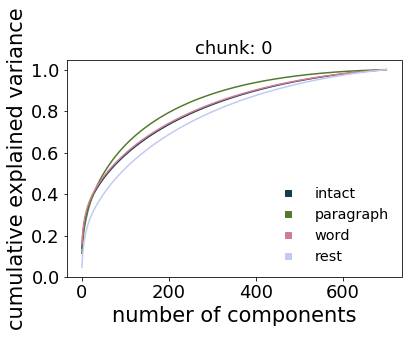

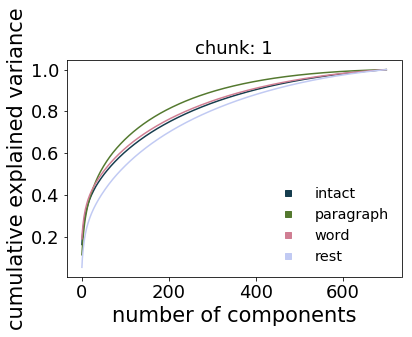

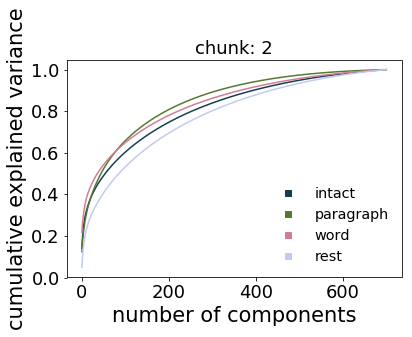

<Figure size 432x288 with 0 Axes>

In [24]:

for chunk in range(chunks):
    data = np.array(data_chunks[chunk])
    conds = np.array(conds_chunks[chunk])
    
    conditions = ['intact', 'paragraph', 'word', 'rest']
    colors = sns.color_palette("cubehelix", 4)

    for e, c in enumerate(conditions):
        x = list(data[conds == c])
        split = np.cumsum([len(xi) for xi in x])[:-1]

        pca = IncrementalPCA(n_components=np.shape(x)[2])
        x_r = np.vsplit(pca.fit_transform(np.vstack(x)), split)

        plt.plot(np.cumsum(pca.explained_variance_ratio_), color = colors[e])
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance')
        plt.title('chunk: ' + str(chunk))

    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
    legend = plt.legend([f("s", colors[i]) for i in range(4)], conditions, loc=4, framealpha=1, frameon=False, fontsize = 'x-large')
    
    plt.show()
    plt.clf()

# Make scree plot for first 5 components

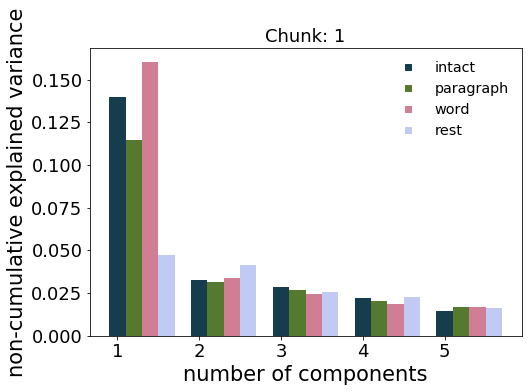

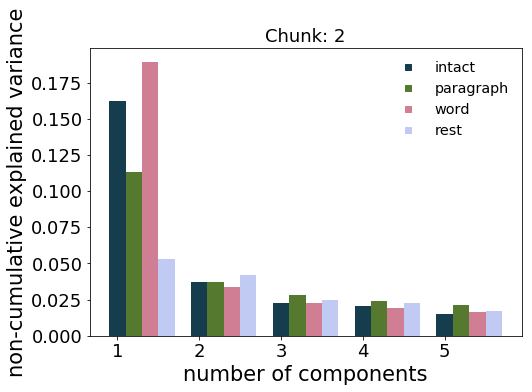

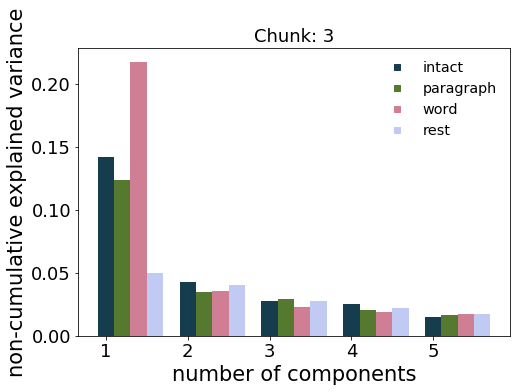

In [25]:
for chunk in range(chunks):
    data = np.array(data_chunks[chunk])
    conds = np.array(conds_chunks[chunk])
    
    conditions = ['intact', 'paragraph', 'word', 'rest']
    colors = sns.color_palette("cubehelix", 4)

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    X = np.arange(5)
    x_new = 0 
    for e, c in enumerate(conditions):

        x = list(data[conds == c])
        split = np.cumsum([len(xi) for xi in x])[:-1]

        pca = IncrementalPCA(n_components=np.shape(x)[2])
        x_r = np.vsplit(pca.fit_transform(np.vstack(x)), split)


        ax.bar(X + 1 + x_new, pca.explained_variance_ratio_[:5], color = colors[e], width = 0.2)
        #plt.plot(pca.explained_variance_ratio_, color = colors[e])
        plt.xlabel('number of components')
        plt.ylabel('non-cumulative explained variance')
        plt.title('Chunk: ' + str(chunk + 1))
        x_new += 0.2

    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
    legend = plt.legend([f("s", colors[i]) for i in range(4)], conditions, loc=1, framealpha=1, frameon=False, fontsize = 'x-large')


# Plot cumulative variance explained by number of components for each condition and chunk


In [29]:
conditions = ['intact', 'paragraph', 'word', 'rest']
#conditions = ['intact']
colors = sns.color_palette("cubehelix", 4)

full_pca_data = pd.DataFrame()
for e, c in enumerate(conditions):
    
    for p in np.arange(data[conds == c].shape[0]):
    
        x = data[conds == c][p]
        #split = np.cumsum([len(xi) for xi in x])[:-1]

        pca = PCA(n_components=700)
        pca.fit_transform(x)
        #x_r = np.vsplit(pca.fit_transform(np.vstack(x)), split)

#         plt.plot(np.cumsum(pca.explained_variance_ratio_), color = colors[e])
#         plt.xlabel('number of components')
#         plt.ylabel('cumulative explained variance')


        pc_data = pd.DataFrame()
        pc_data['variance'] = np.cumsum(pca.explained_variance_ratio_)
        pc_data['condition'] = np.matlib.repmat(c, np.cumsum(pca.explained_variance_ratio_).shape[0], 1)
        pc_data['subject'] = np.matlib.repmat(p, np.cumsum(pca.explained_variance_ratio_).shape[0], 1)
        pc_data['components'] = pc_data.index +1 
        if full_pca_data.empty:
            full_pca_data = pc_data
        else:
            full_pca_data = full_pca_data.append(pc_data)

In [28]:
sub_nii = se.load('std', vox_size=4)
sub_locs = sub_nii.get_locs().values

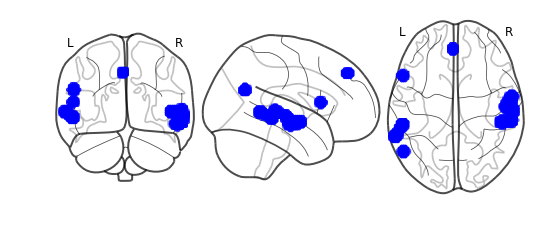

../../data/niis/pcas/intact_1_pca_chunk_smallest_change3
Condition = intact; Chunk = 3; PCA = 1


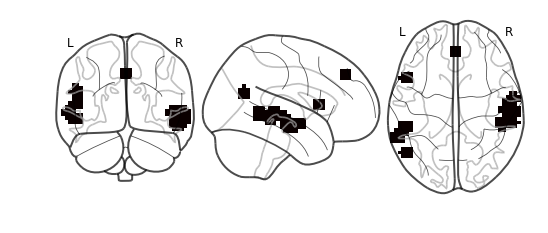

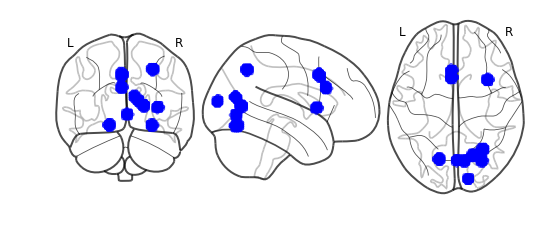

../../data/niis/pcas/intact_1_pca_chunk_largest_change3
Condition = intact; Chunk = 3; PCA = 1


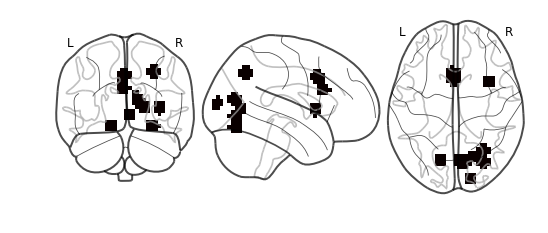

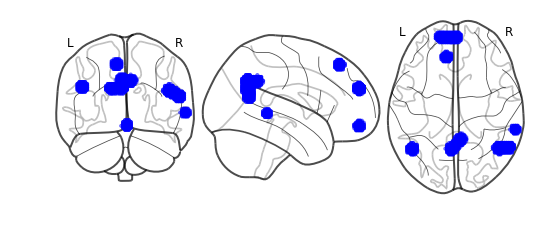

../../data/niis/pcas/intact_2_pca_chunk_smallest_change3
Condition = intact; Chunk = 3; PCA = 2


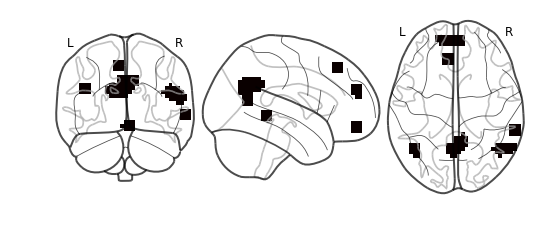

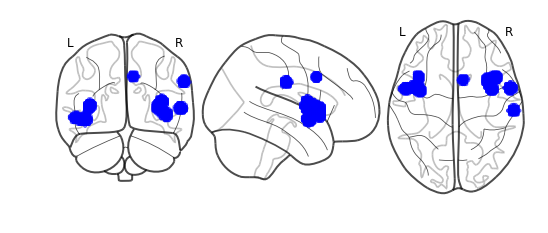

../../data/niis/pcas/intact_2_pca_chunk_largest_change3
Condition = intact; Chunk = 3; PCA = 2


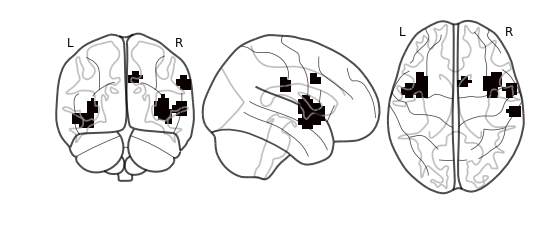

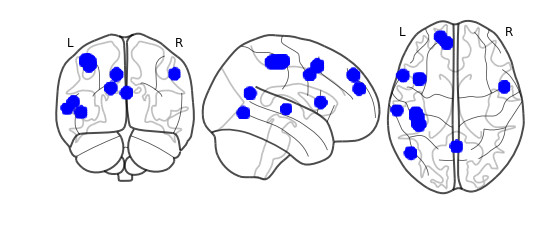

../../data/niis/pcas/intact_3_pca_chunk_smallest_change3
Condition = intact; Chunk = 3; PCA = 3


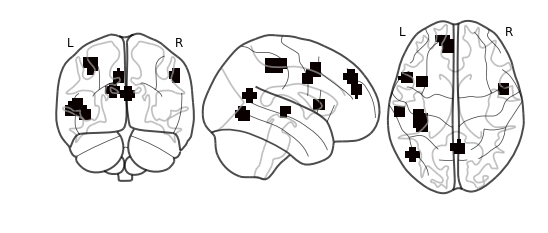

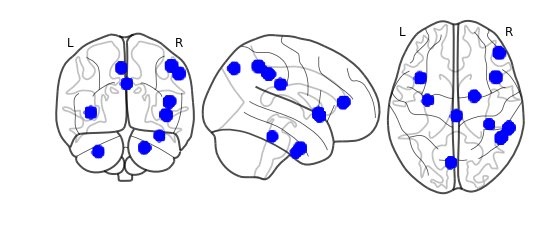

../../data/niis/pcas/intact_3_pca_chunk_largest_change3
Condition = intact; Chunk = 3; PCA = 3


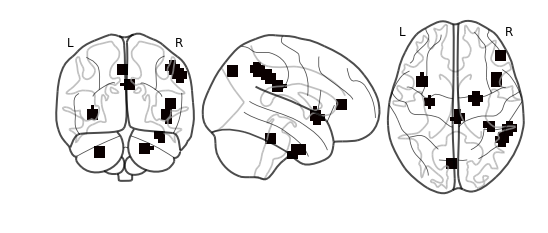

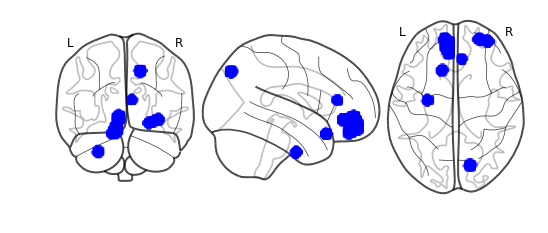

../../data/niis/pcas/intact_4_pca_chunk_smallest_change3
Condition = intact; Chunk = 3; PCA = 4


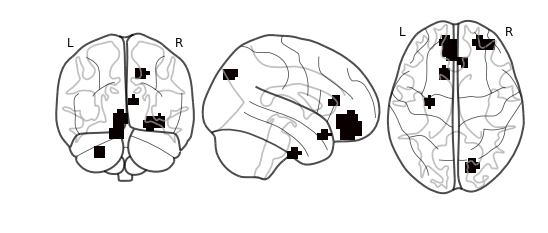

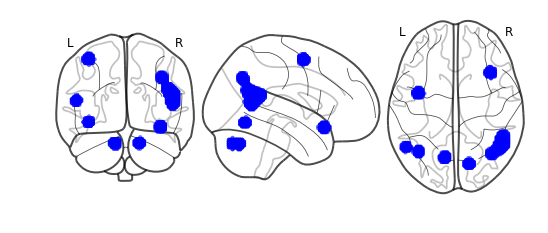

../../data/niis/pcas/intact_4_pca_chunk_largest_change3
Condition = intact; Chunk = 3; PCA = 4


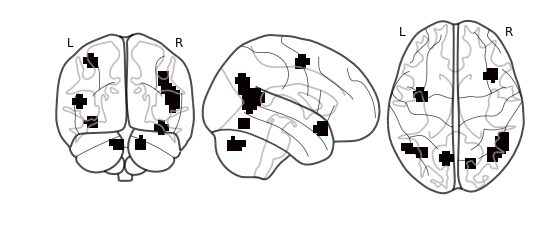

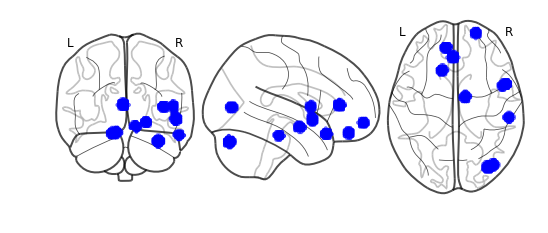

../../data/niis/pcas/intact_5_pca_chunk_smallest_change3
Condition = intact; Chunk = 3; PCA = 5


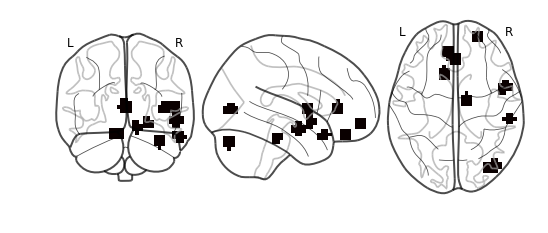

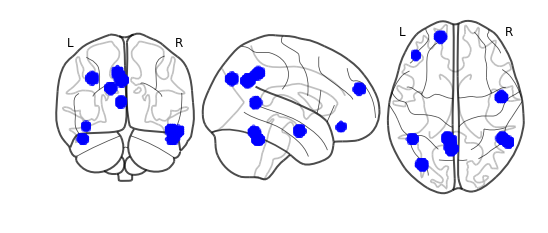

../../data/niis/pcas/intact_5_pca_chunk_largest_change3
Condition = intact; Chunk = 3; PCA = 5


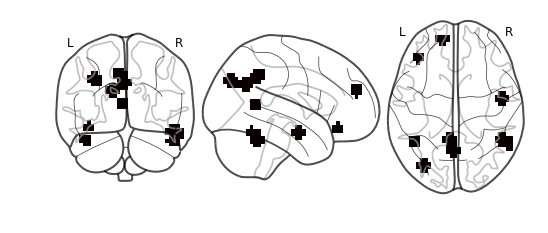

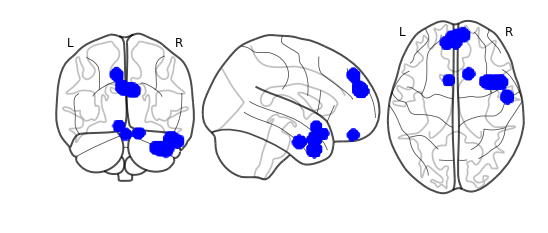

../../data/niis/pcas/paragraph_1_pca_chunk_smallest_change3
Condition = paragraph; Chunk = 3; PCA = 1


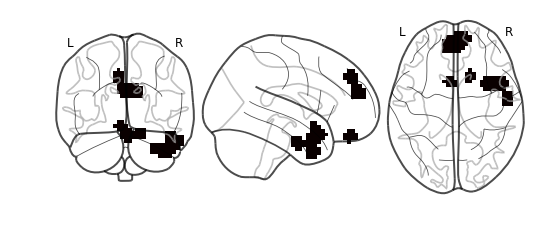

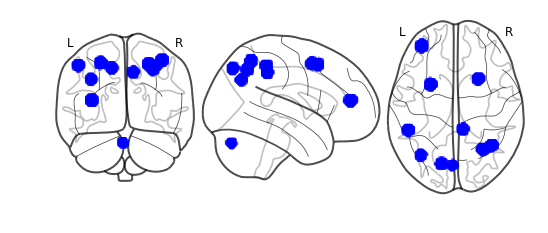

../../data/niis/pcas/paragraph_1_pca_chunk_largest_change3
Condition = paragraph; Chunk = 3; PCA = 1


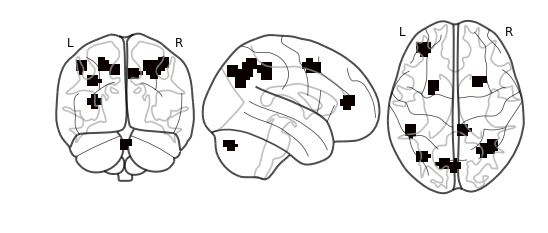

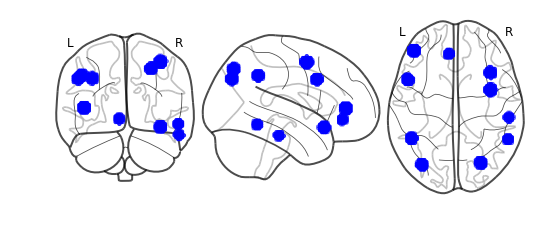

../../data/niis/pcas/paragraph_2_pca_chunk_smallest_change3
Condition = paragraph; Chunk = 3; PCA = 2


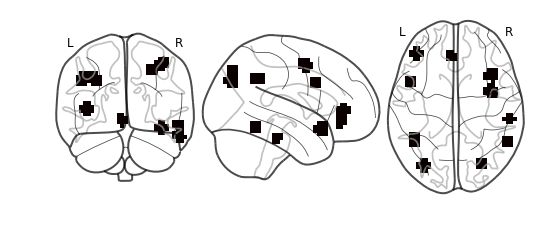

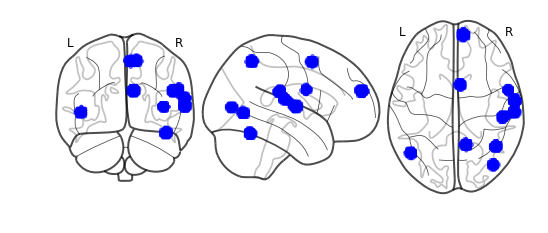

../../data/niis/pcas/paragraph_2_pca_chunk_largest_change3
Condition = paragraph; Chunk = 3; PCA = 2


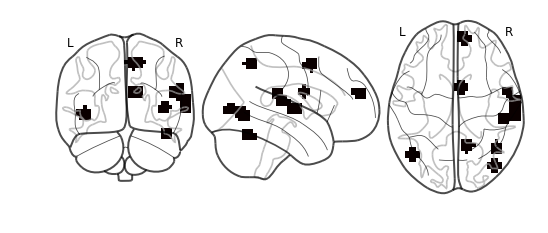

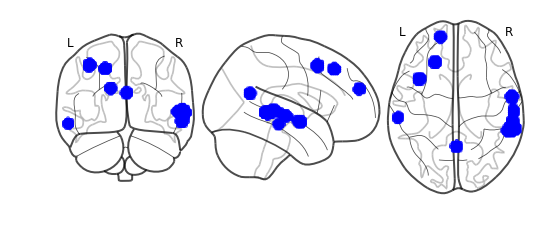

../../data/niis/pcas/paragraph_3_pca_chunk_smallest_change3
Condition = paragraph; Chunk = 3; PCA = 3


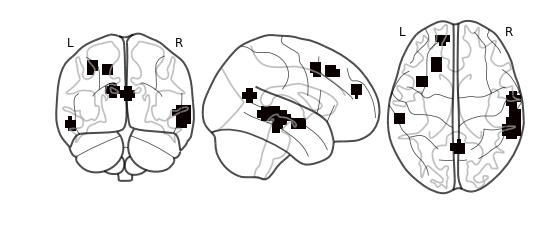

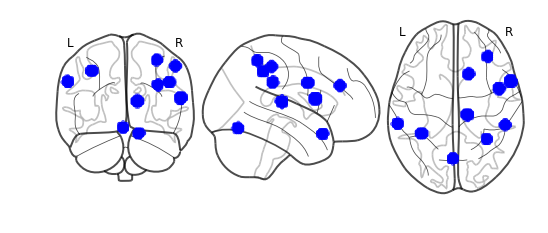

../../data/niis/pcas/paragraph_3_pca_chunk_largest_change3
Condition = paragraph; Chunk = 3; PCA = 3


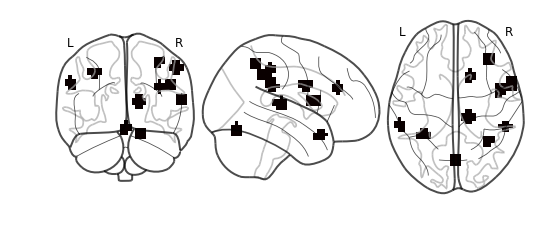

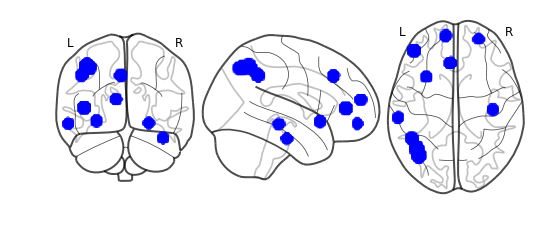

../../data/niis/pcas/paragraph_4_pca_chunk_smallest_change3
Condition = paragraph; Chunk = 3; PCA = 4


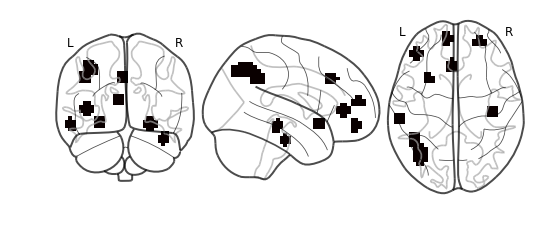

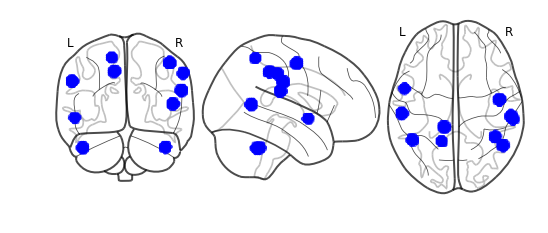

../../data/niis/pcas/paragraph_4_pca_chunk_largest_change3
Condition = paragraph; Chunk = 3; PCA = 4


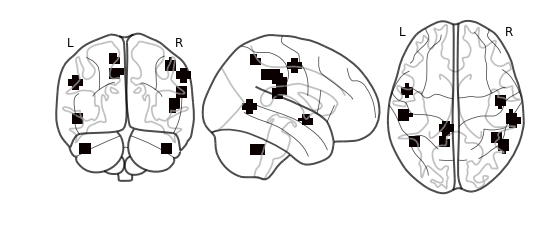

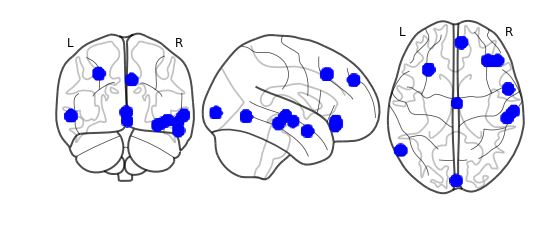

../../data/niis/pcas/paragraph_5_pca_chunk_smallest_change3
Condition = paragraph; Chunk = 3; PCA = 5


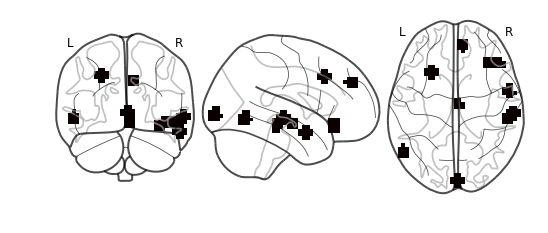

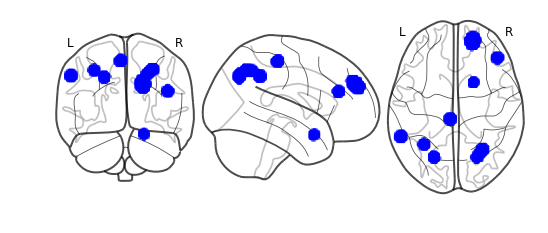

../../data/niis/pcas/paragraph_5_pca_chunk_largest_change3
Condition = paragraph; Chunk = 3; PCA = 5


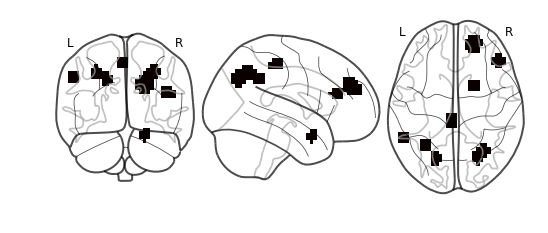

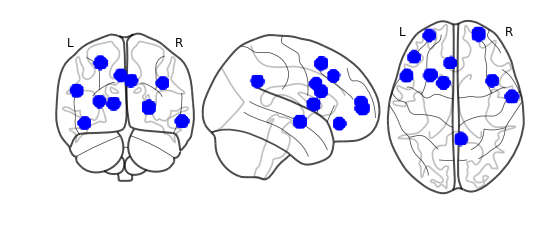

../../data/niis/pcas/word_1_pca_chunk_smallest_change3
Condition = word; Chunk = 3; PCA = 1


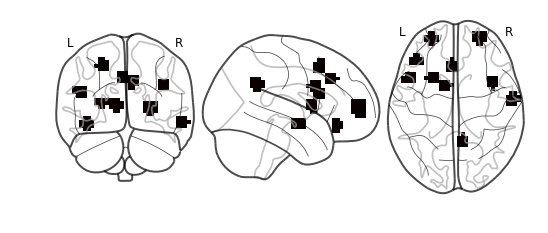

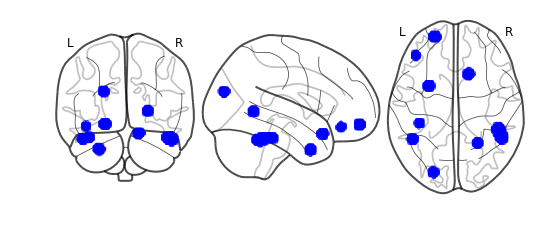

../../data/niis/pcas/word_1_pca_chunk_largest_change3
Condition = word; Chunk = 3; PCA = 1


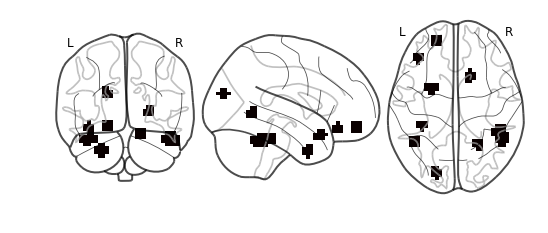

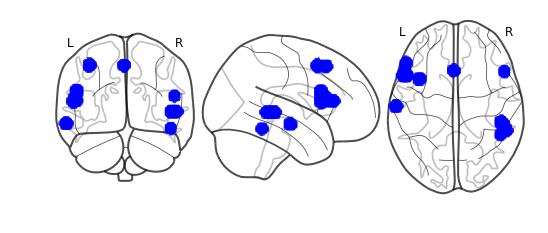

../../data/niis/pcas/word_2_pca_chunk_smallest_change3
Condition = word; Chunk = 3; PCA = 2


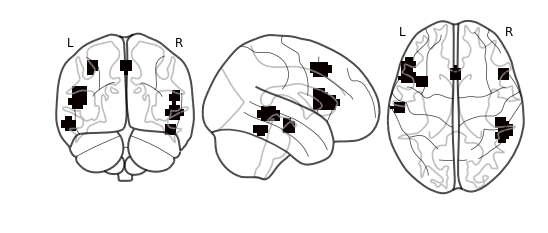

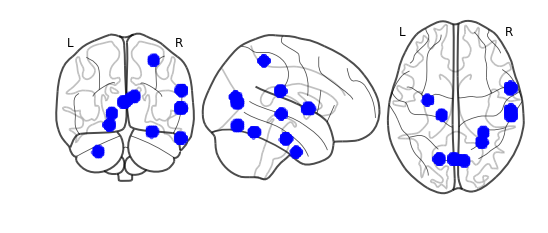

../../data/niis/pcas/word_2_pca_chunk_largest_change3
Condition = word; Chunk = 3; PCA = 2


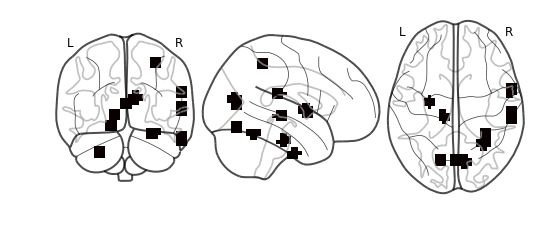

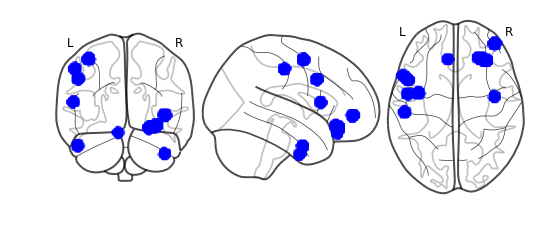

../../data/niis/pcas/word_3_pca_chunk_smallest_change3
Condition = word; Chunk = 3; PCA = 3


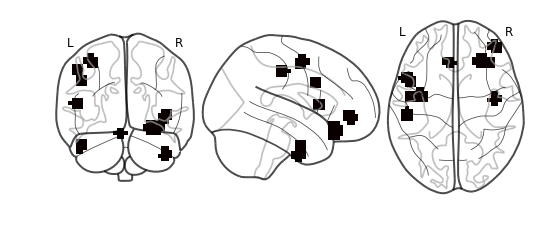

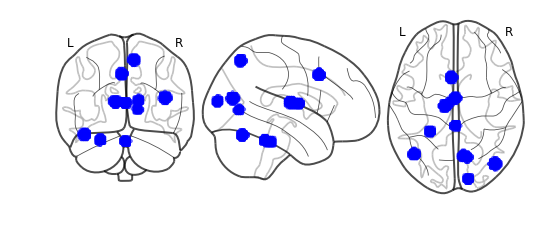

../../data/niis/pcas/word_3_pca_chunk_largest_change3
Condition = word; Chunk = 3; PCA = 3


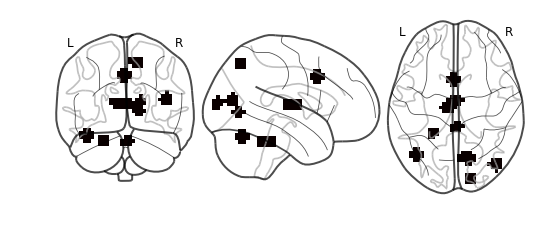

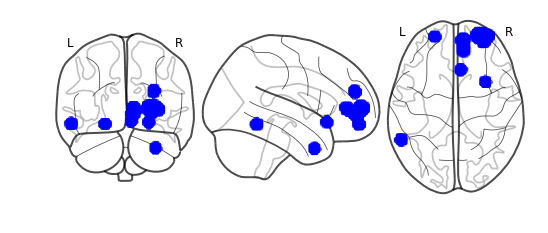

../../data/niis/pcas/word_4_pca_chunk_smallest_change3
Condition = word; Chunk = 3; PCA = 4


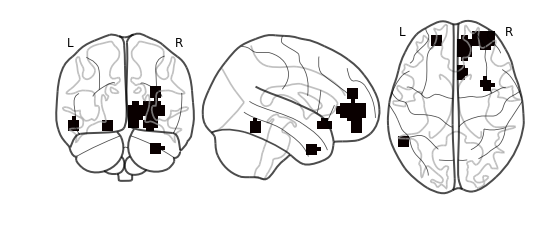

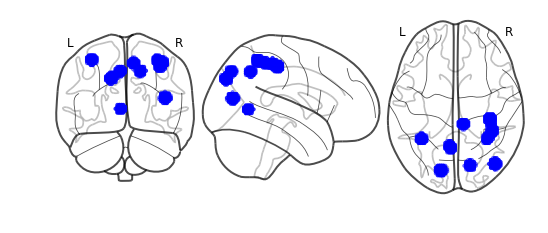

../../data/niis/pcas/word_4_pca_chunk_largest_change3
Condition = word; Chunk = 3; PCA = 4


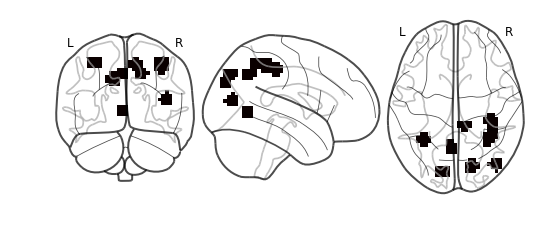

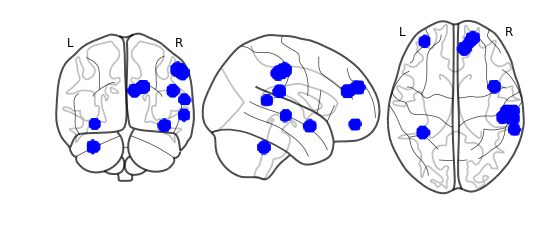

../../data/niis/pcas/word_5_pca_chunk_smallest_change3
Condition = word; Chunk = 3; PCA = 5


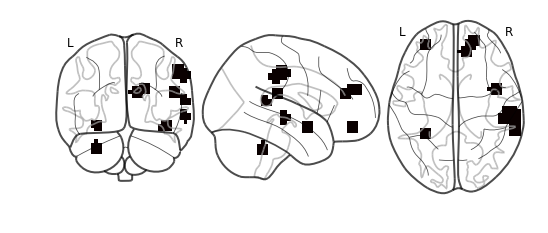

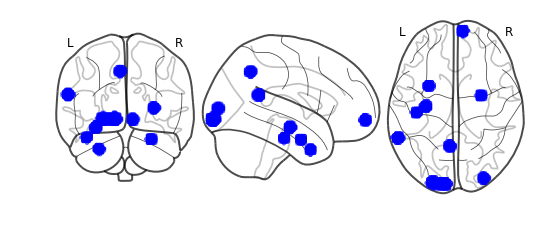

../../data/niis/pcas/word_5_pca_chunk_largest_change3
Condition = word; Chunk = 3; PCA = 5


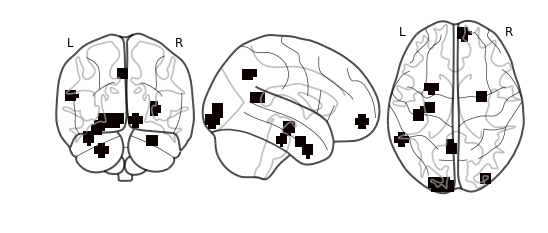

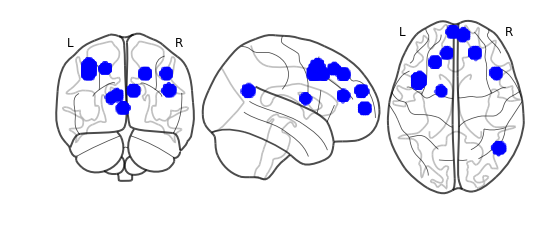

../../data/niis/pcas/rest_1_pca_chunk_smallest_change3
Condition = rest; Chunk = 3; PCA = 1


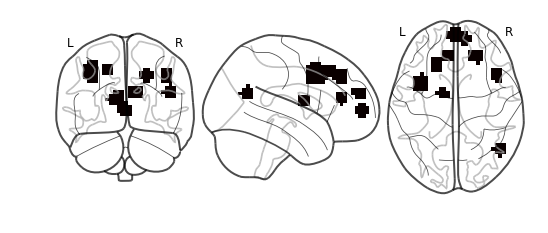

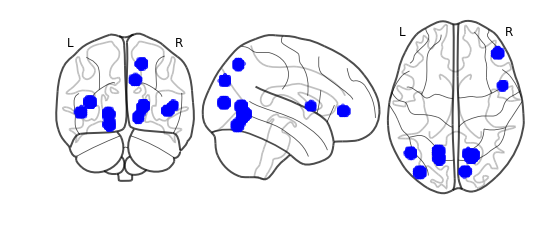

../../data/niis/pcas/rest_1_pca_chunk_largest_change3
Condition = rest; Chunk = 3; PCA = 1


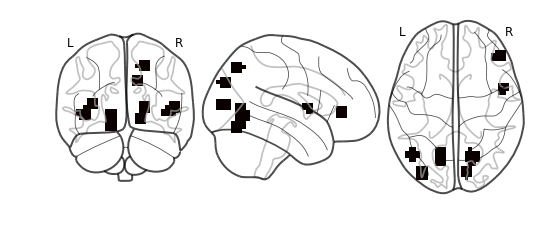

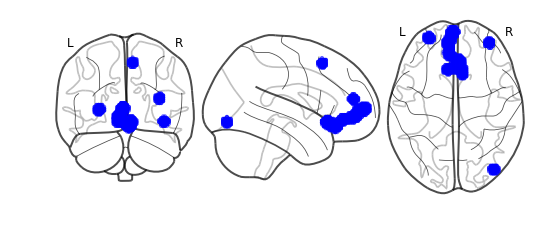

../../data/niis/pcas/rest_2_pca_chunk_smallest_change3
Condition = rest; Chunk = 3; PCA = 2


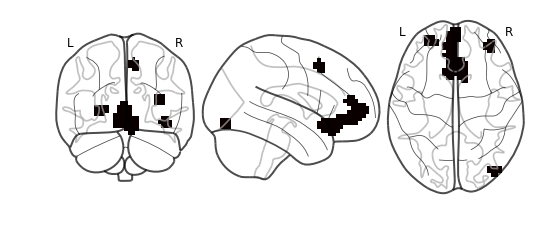

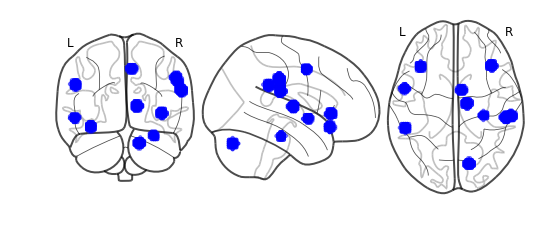

../../data/niis/pcas/rest_2_pca_chunk_largest_change3
Condition = rest; Chunk = 3; PCA = 2


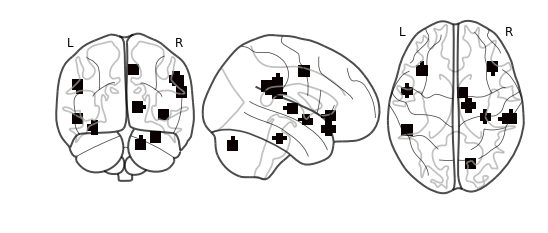

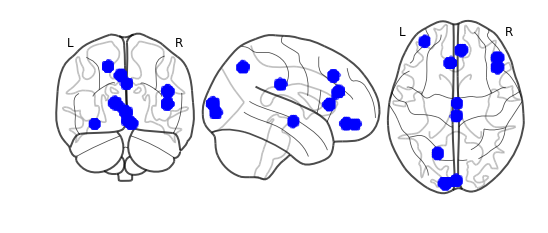

../../data/niis/pcas/rest_3_pca_chunk_smallest_change3
Condition = rest; Chunk = 3; PCA = 3


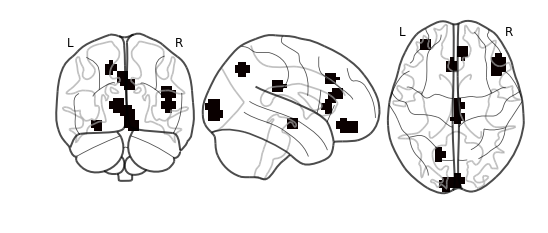

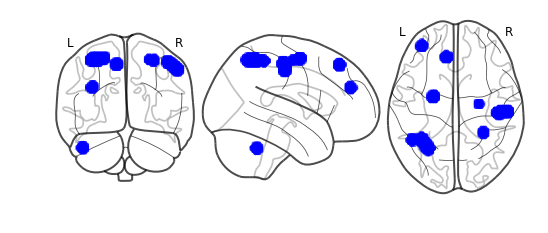

../../data/niis/pcas/rest_3_pca_chunk_largest_change3
Condition = rest; Chunk = 3; PCA = 3


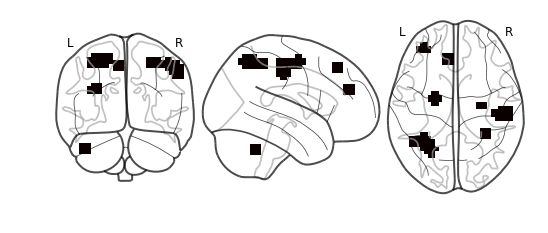

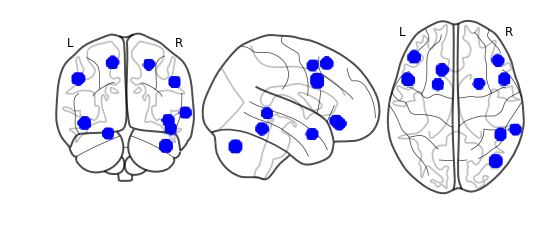

../../data/niis/pcas/rest_4_pca_chunk_smallest_change3
Condition = rest; Chunk = 3; PCA = 4


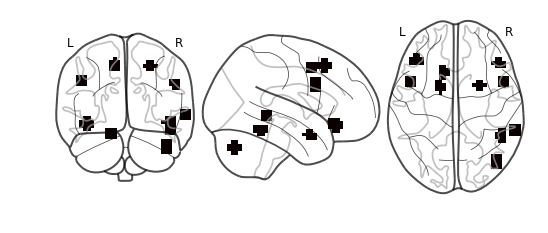

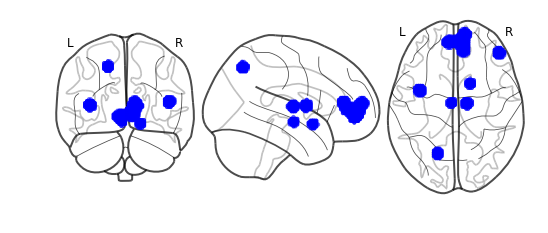

../../data/niis/pcas/rest_4_pca_chunk_largest_change3
Condition = rest; Chunk = 3; PCA = 4


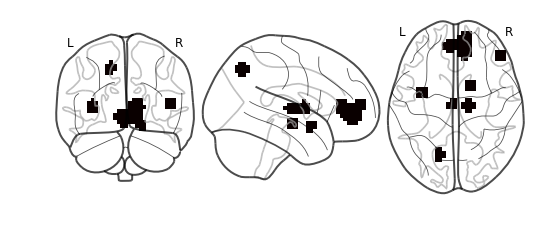

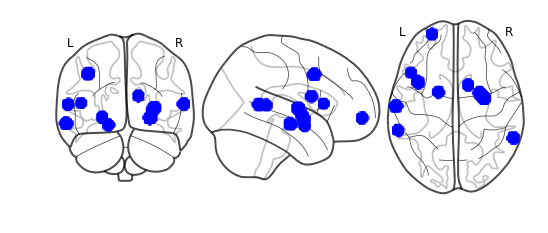

../../data/niis/pcas/rest_5_pca_chunk_smallest_change3
Condition = rest; Chunk = 3; PCA = 5


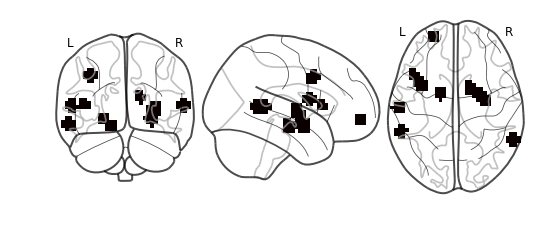

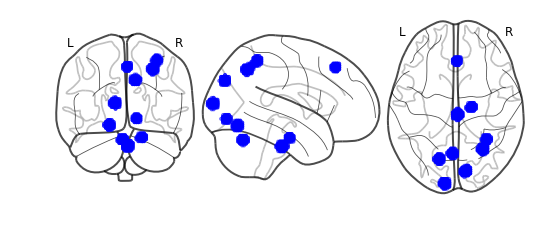

../../data/niis/pcas/rest_5_pca_chunk_largest_change3
Condition = rest; Chunk = 3; PCA = 5


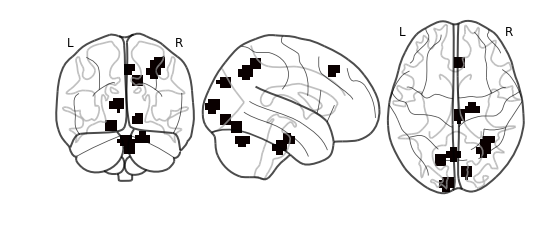

In [48]:
conditions = ['intact', 'paragraph', 'word', 'rest']
#conditions = ['intact', 'paragraph']
colors = sns.color_palette("cubehelix", 4)


for e, c in enumerate(conditions):
    for chunk in range(chunks):
        data = np.array(data_chunks[chunk])
        conds = np.array(conds_chunks[chunk])

        full_pca_data = pd.DataFrame()

        for p in np.arange(data[conds == c].shape[0]):

            x = data[conds == c][p]

            pca = PCA(n_components=100)
            pca.fit_transform(x)

            pc_flatten = pca.components_[:10].flatten('F')
            pc_data = pd.DataFrame()
            pc_data['weights'] = pc_flatten
            pc_data['condition'] = np.matlib.repmat(c, pc_flatten.shape[0], 1)
            pc_data['subject'] = np.matlib.repmat(p, pc_flatten.shape[0], 1)
            pc_data['third'] = np.matlib.repmat(chunk, pc_flatten.shape[0], 1)
            pc_data['components'] = pc_data.index +1 
            if full_pca_data.empty:
                full_pca_data = pc_data
            else:
                full_pca_data = full_pca_data.append(pc_data)

    data_regression = full_pca_data.groupby(['condition', 'components'], 
                       group_keys=False).apply(regress, 'weights', ['third']).reset_index()

    orginal_shape = (10, 700)

    stacked = data_regression['third'].as_matrix().reshape(orginal_shape, order='F')

        #for si in ['largest', 'smallest']:
    for i in np.arange(5):

        net_inds = smallest_indices(stacked[i], 10)
        temp_locs = centers[net_inds]
        temp_widths = widths[net_inds]
        w = rbf(temp_locs, temp_widths, template.get_locs().values)
        b_o = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)

        b_data = b_o.get_data().values.ravel()
        xyz = b_o.get_locs().values
        mask = b_data > .5
        xyz = xyz[mask]
        b_data = b_data[mask]
        b_data = np.ones(b_data.shape)+i

        b = se.Brain(data=np.atleast_2d(b_data), locs=xyz)
        b.filter = None
        b.plot_locs()
        outfile = os.path.join(pca_nii_bo_dir, c + '_' + str(i+1) + '_pca_chunk_smallest_change' + str(chunk+1))
        print(outfile)
        b.save(outfile)

        nii = se.helpers._brain_to_nifti(b, sub_nii)
        nii.get_data()[nii.get_data() > 0] = 1
        ##nii = se.Nifti(b_o, affine = template.get_affine())
        print('Condition = ' + c + '; Chunk = ' + str(chunk + 1) + '; PCA = ' + str(i+ 1))
        nii.plot_glass_brain()
        nii.save(outfile)

        net_inds = largest_indices(stacked[i], 10)
        temp_locs = centers[net_inds]
        temp_widths = widths[net_inds]
        w = rbf(temp_locs, temp_widths, template.get_locs().values)
        b_o = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)

        b_data = b_o.get_data().values.ravel()
        xyz = b_o.get_locs().values
        mask = b_data > .5
        xyz = xyz[mask]
        b_data = b_data[mask]
        b_data = np.ones(b_data.shape)+i

        b = se.Brain(data=np.atleast_2d(b_data), locs=xyz)
        b.filter = None
        b.plot_locs()
        outfile = os.path.join(pca_nii_bo_dir, c + '_' + str(i+1) + '_pca_chunk_largest_change' + str(chunk+1))
        print(outfile)
        b.save(outfile)

        nii = se.helpers._brain_to_nifti(b, sub_nii)
        nii.get_data()[nii.get_data() > 0] = 1
        ##nii = se.Nifti(b_o, affine = template.get_affine())
        print('Condition = ' + c + '; Chunk = ' + str(chunk + 1) + '; PCA = ' + str(i+ 1))
        nii.plot_glass_brain()
        nii.save(outfile)


In [ ]:
# #conditions = ['intact', 'paragraph', 'word', 'rest']
# conditions = ['intact']
# colors = sns.color_palette("cubehelix", 4)


# intact_stack = np.empty([10, 700])
# for hub in range(700):
#     for chunk in range(chunks):
#         data = np.array(data_chunks[chunk])
#         conds = np.array(conds_chunks[chunk])

#         full_pca_data = pd.DataFrame()
#         for e, c in enumerate(conditions):

#             for p in np.arange(data[conds == c].shape[0]):

#                 x = data[conds == c][p]
#                 #split = np.cumsum([len(xi) for xi in x])[:-1]

#                 pca = PCA(n_components=100)
#                 pca.fit_transform(x)
#                 #x_r = np.vsplit(pca.fit_transform(np.vstack(x)), split)

#         #         plt.plot(np.cumsum(pca.explained_variance_ratio_), color = colors[e])
#         #         plt.xlabel('number of components')
#         #         plt.ylabel('cumulative explained variance')


#                 pc_data = pd.DataFrame()
#                 pc_data['weights'] = pca.components_[:10, hub]
#                 pc_data['condition'] = np.matlib.repmat(c, pca.components_[:10, hub].shape[0], 1)
#                 pc_data['subject'] = np.matlib.repmat(p, pca.components_[:10, hub].shape[0], 1)
#                 pc_data['third'] = np.matlib.repmat(chunk, pca.components_[:10, hub].shape[0], 1)
#                 pc_data['components'] = pc_data.index +1 
#                 if full_pca_data.empty:
#                     full_pca_data = pc_data
#                 else:
#                     full_pca_data = full_pca_data.append(pc_data)

#     data_regression = full_pca_data.groupby(['condition', 'components'], 
#                        group_keys=False).apply(regress, 'weights', ['third']).reset_index()


#     intact_stack[:, hub] = data_regression['third'].as_matrix()

In [43]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = matplotlib.cm.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i) 
    return(colors_rgba[:N, :3])

In [44]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [46]:
import matplotlib

rgba = cmap_discretize('RdBu_r', 10)

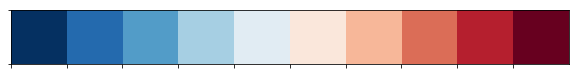

In [47]:
sns.palplot(rgba)

In [ ]:
net_inds = smallest_indices(np.abs(intact_stack[0]), 10)

In [ ]:
net_inds[0]

In [ ]:
intact_stack[0].min()

In [ ]:
intact_stack[0, net_inds[0]]

In [ ]:
for i in range(10):
    net_inds = smallest_indices(stacked[i], 10)
    temp_locs = centers[net_inds]
    temp_widths = widths[net_inds]
    w = rbf(temp_locs, temp_widths, template.get_locs().values)
    b_o = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)
    b_data = b_o.get_data().values.ravel()
    xyz = b_o.get_locs().values
    mask = b_data > .5
    xyz = xyz[mask]
    b_data = b_data[mask]
    b_data = np.ones(b_data.shape)+1
    b = se.Brain(data=np.atleast_2d(b_data), locs=xyz)
    b.filter = None
    b.plot_locs()

In [ ]:
for i in range(10):
    net_inds = smallest_indices(intact_stack[i], 10)
    temp_locs = centers[net_inds]
    temp_widths = widths[net_inds]
    w = rbf(temp_locs, temp_widths, template.get_locs().values)
    b_o = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)
    b_data = b_o.get_data().values.ravel()
    xyz = b_o.get_locs().values
    mask = b_data > .5
    xyz = xyz[mask]
    b_data = b_data[mask]
    b_data = np.ones(b_data.shape)+1
    b = se.Brain(data=np.atleast_2d(b_data), locs=xyz)
    b.filter = None
    b.plot_locs()

In [ ]:
for i in range(10):
    net_inds = largest_indices(intact_stack[i], 10)
    temp_locs = centers[net_inds]
    temp_widths = widths[net_inds]
    w = rbf(temp_locs, temp_widths, template.get_locs().values)
    b_o = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)
    b_data = b_o.get_data().values.ravel()
    xyz = b_o.get_locs().values
    mask = b_data > .5
    xyz = xyz[mask]
    b_data = b_data[mask]
    b_data = np.ones(b_data.shape)+1
    b = se.Brain(data=np.atleast_2d(b_data), locs=xyz)
    b.filter = None
    b.plot_locs()

In [ ]:
temp_locs = centers[net_inds]
temp_widths = widths[net_inds]

In [ ]:
w = rbf(temp_locs, temp_widths, template.get_locs().values)
b_o = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)


In [ ]:
b_data = b_o.get_data().values.ravel()
xyz = b_o.get_locs().values
mask = b_data > .5
xyz = xyz[mask]
b_data = b_data[mask]
b_data = np.ones(b_data.shape)+1

In [ ]:
b = se.Brain(data=np.atleast_2d(b_data), locs=xyz)
b.filter = None
b.plot_locs()

In [ ]:
data_regression = full_pca_data.groupby(['condition', 'components'], 
                           group_keys=False).apply(regress, 'weights', ['third']).reset_index()

In [ ]:
np.stack((data_regression['third'].as_matrix(), data_regression['third'].as_matrix()), axis=-1)

In [ ]:
regress(full_pca_data, 'weights', ['third'])[0]

In [ ]:
pca.components_.shape

In [ ]:
net_inds[1]

In [ ]:
pca.components_.shape

In [ ]:
chunks = 3
conditions = ['intact', 'paragraph', 'word', 'rest']
#conditions = ['intact']
colors = sns.color_palette("cubehelix", 4)

for chunk in range(chunks):
    data = np.array(data_chunks[chunk])
    conds = np.array(conds_chunks[chunk])

    for e, c in enumerate(conditions):

        x = list(data[conds == c])
        
        split = np.cumsum([len(xi) for xi in x])[:-1]

        pca = IncrementalPCA(n_components=700)
        print(pca)
        x_r = np.vsplit(pca.fit_transform(np.vstack(x)), split)
        for i in np.arange(5):

            print(pca.components_)
            plt.show()
            net_inds = largest_indices(pca.components_[i], 10)
            temp_locs = centers[net_inds]
            temp_widths = widths[net_inds]
            w = rbf(temp_locs, temp_widths, template.get_locs().values)
            b_o = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs=template.get_locs(), minimum_voxel_size=2)

            b_data = b_o.get_data().values.ravel()
            xyz = b_o.get_locs().values
            mask = b_data > .5
            xyz = xyz[mask]
            b_data = b_data[mask]
            b_data = np.ones(b_data.shape)+i

            b = se.Brain(data=np.atleast_2d(b_data), locs=xyz)
            b.filter = None
            b.plot_locs()
            outfile = os.path.join(pca_nii_bo_dir, c + '_' + str(i+1) + '_pca_chunk_' + str(chunk+1))
            print(outfile)
            b.save(outfile)

            nii = se.helpers._brain_to_nifti(b, sub_nii)
            nii.get_data()[nii.get_data() > 0] = 1
            ##nii = se.Nifti(b_o, affine = template.get_affine())
            print('Condition = ' + c + '; Chunk = ' + str(chunk + 1) + '; PCA = ' + str(i+ 1) + '; Variance explained = ' + str(np.round(pca.explained_variance_ratio_[i],2)))
            nii.plot_glass_brain()
            nii.save(outfile)